Steane code error correction with  noise
=================================

1. Set up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up the ancilla

3. Set up the error correction circuit.  There are options to set this circuit up with and without MCT gates.

3. Because of the number of gates in the error correction circuit the error correction process itself produces considerable errors.

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

from circuits import SteaneCodeLogicalQubit

import matplotlib.pyplot as plt
import numpy as np

from helper_functions import (
    count_valid_output_strings,
    find_individual_ancilla_values,
    find_ancilla_values,
    find_parity,
    get_noise,
    mean_of_list,
    calculate_standard_error,
    print_time,
    get_parity_check_matrix,
    get_codewords
    )

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_SET = ['id', 'ry', 'rx']
TWO_GATE_SET = ['rxx']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET

ERROR_REDUCTION = 1
ITERATIONS = 25

NOISE = True                                              #Test with noise
SHOTS = 1000                                              #Number of shots to run 
MEASURE_NOISE = 0.0046 * ERROR_REDUCTION                  #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366 * ERROR_REDUCTION     #Single gate noise   
TWO_GATE_DEPOLARISING = 0.022 * ERROR_REDUCTION 

SIMULATOR = Aer.get_backend('qasm_simulator')

Specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = get_parity_check_matrix()
print(parity_check_matrix)

['0001111', '0110011', '1010101']


The allowed codewords for the zero logical from Nielsen and Chuang is stored in a list.  Note, the order of qubits in the list is reversed compared to the normal output of Qiskit.

In [4]:
codewords = get_codewords()
print(codewords)

['0000000', '1010101', '0110011', '1100110', '0001111', '1011010', '0111100', '1101001']


Error correction
-----------------------

The error correction circuit is added to the encoding circuit and ancilla and transpiled.  There are two possible circuits, those with Multi Control Toffoli (MCT) gates, and those without.

After error correction the noise is assessed.

In [5]:
for ps in [False, True]:
#ps = post_selection
    if ps:
        print('Results with post selection')
    else:
        print('Results without post selection')
    for mct in [False, True]:
        print_time()
        if mct:
            print('  With MCT the results are')
        else:
            print('  Without MCT the results are')
        simulation_result = []
        for iteration in range(ITERATIONS):
            if mct:
                qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, extend_ancilla = False)
            else:
                qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, extend_ancilla = True)
            qubit.set_up_logical_zero()
            qubit.barrier()
            qubit.barrier()
            qubit.set_up_ancilla()
            qubit.barrier()
            if mct:     #Multi Control Toffoli (MCT) gates
                qubit.correct_errors(mct = True)
            else:
                qubit.correct_errors()
            qubit.barrier()
            if NOISE:
                noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, TWO_GATE_DEPOLARISING,
                                       SINGLE_GATE_SET, TWO_GATE_SET)
            qubit.logical_measure_data()
            qubit.logical_measure_ancilla()
            qubit.barrier()
            qt = transpile(qubit, basis_gates = BASIS_GATE_SET)
            if NOISE:
                result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
            else:
                result = execute(qt, SIMULATOR, shots = SHOTS).result()
            counts = result.get_counts(qt)
            #print ('The different states can be counted.  The simulated result are', counts)
            if mct:
                count_valid, count_invalid, count_outside_codeword = count_valid_output_strings(counts, codewords, 2,
                                                                                               post_selection = ps 
                                                                                               )
            else:
                count_valid, count_invalid, count_outside_codeword = count_valid_output_strings(counts, codewords, 3,
                                                                                               post_selection = ps 
                                                                                               )
            error_rate = count_invalid / SHOTS
            simulation_result.append(error_rate)
            print(f'The error rate is {error_rate:.4f} for iteration {iteration}')
            print_time()
        mean = mean_of_list(simulation_result) 
        standard_deviation, standard_error = calculate_standard_error(simulation_result)
        print(f'   The average error rate is {mean:.4f}.')
        print(f'   The standard deviation is {standard_deviation:.4f}') 
        print(f'   The standard error is {standard_error:.4f}')
        print()

Results without post selection
Current Time = 21:56:32
  Without MCT the results are
The error rate is 0.7400 for iteration 0
Current Time = 21:57:15
The error rate is 0.7280 for iteration 1
Current Time = 21:58:04
The error rate is 0.7110 for iteration 2
Current Time = 21:58:52
The error rate is 0.7160 for iteration 3
Current Time = 21:59:40
The error rate is 0.7370 for iteration 4
Current Time = 22:00:30
The error rate is 0.7070 for iteration 5
Current Time = 22:01:19
The error rate is 0.6980 for iteration 6
Current Time = 22:02:09
The error rate is 0.7170 for iteration 7
Current Time = 22:02:58
The error rate is 0.7450 for iteration 8
Current Time = 22:03:47
The error rate is 0.7070 for iteration 9
Current Time = 22:04:35
The error rate is 0.6940 for iteration 10
Current Time = 22:05:25
The error rate is 0.7270 for iteration 11
Current Time = 22:06:14
The error rate is 0.6810 for iteration 12
Current Time = 22:07:02
The error rate is 0.7190 for iteration 13
Current Time = 22:07:51
T

Draw circuit

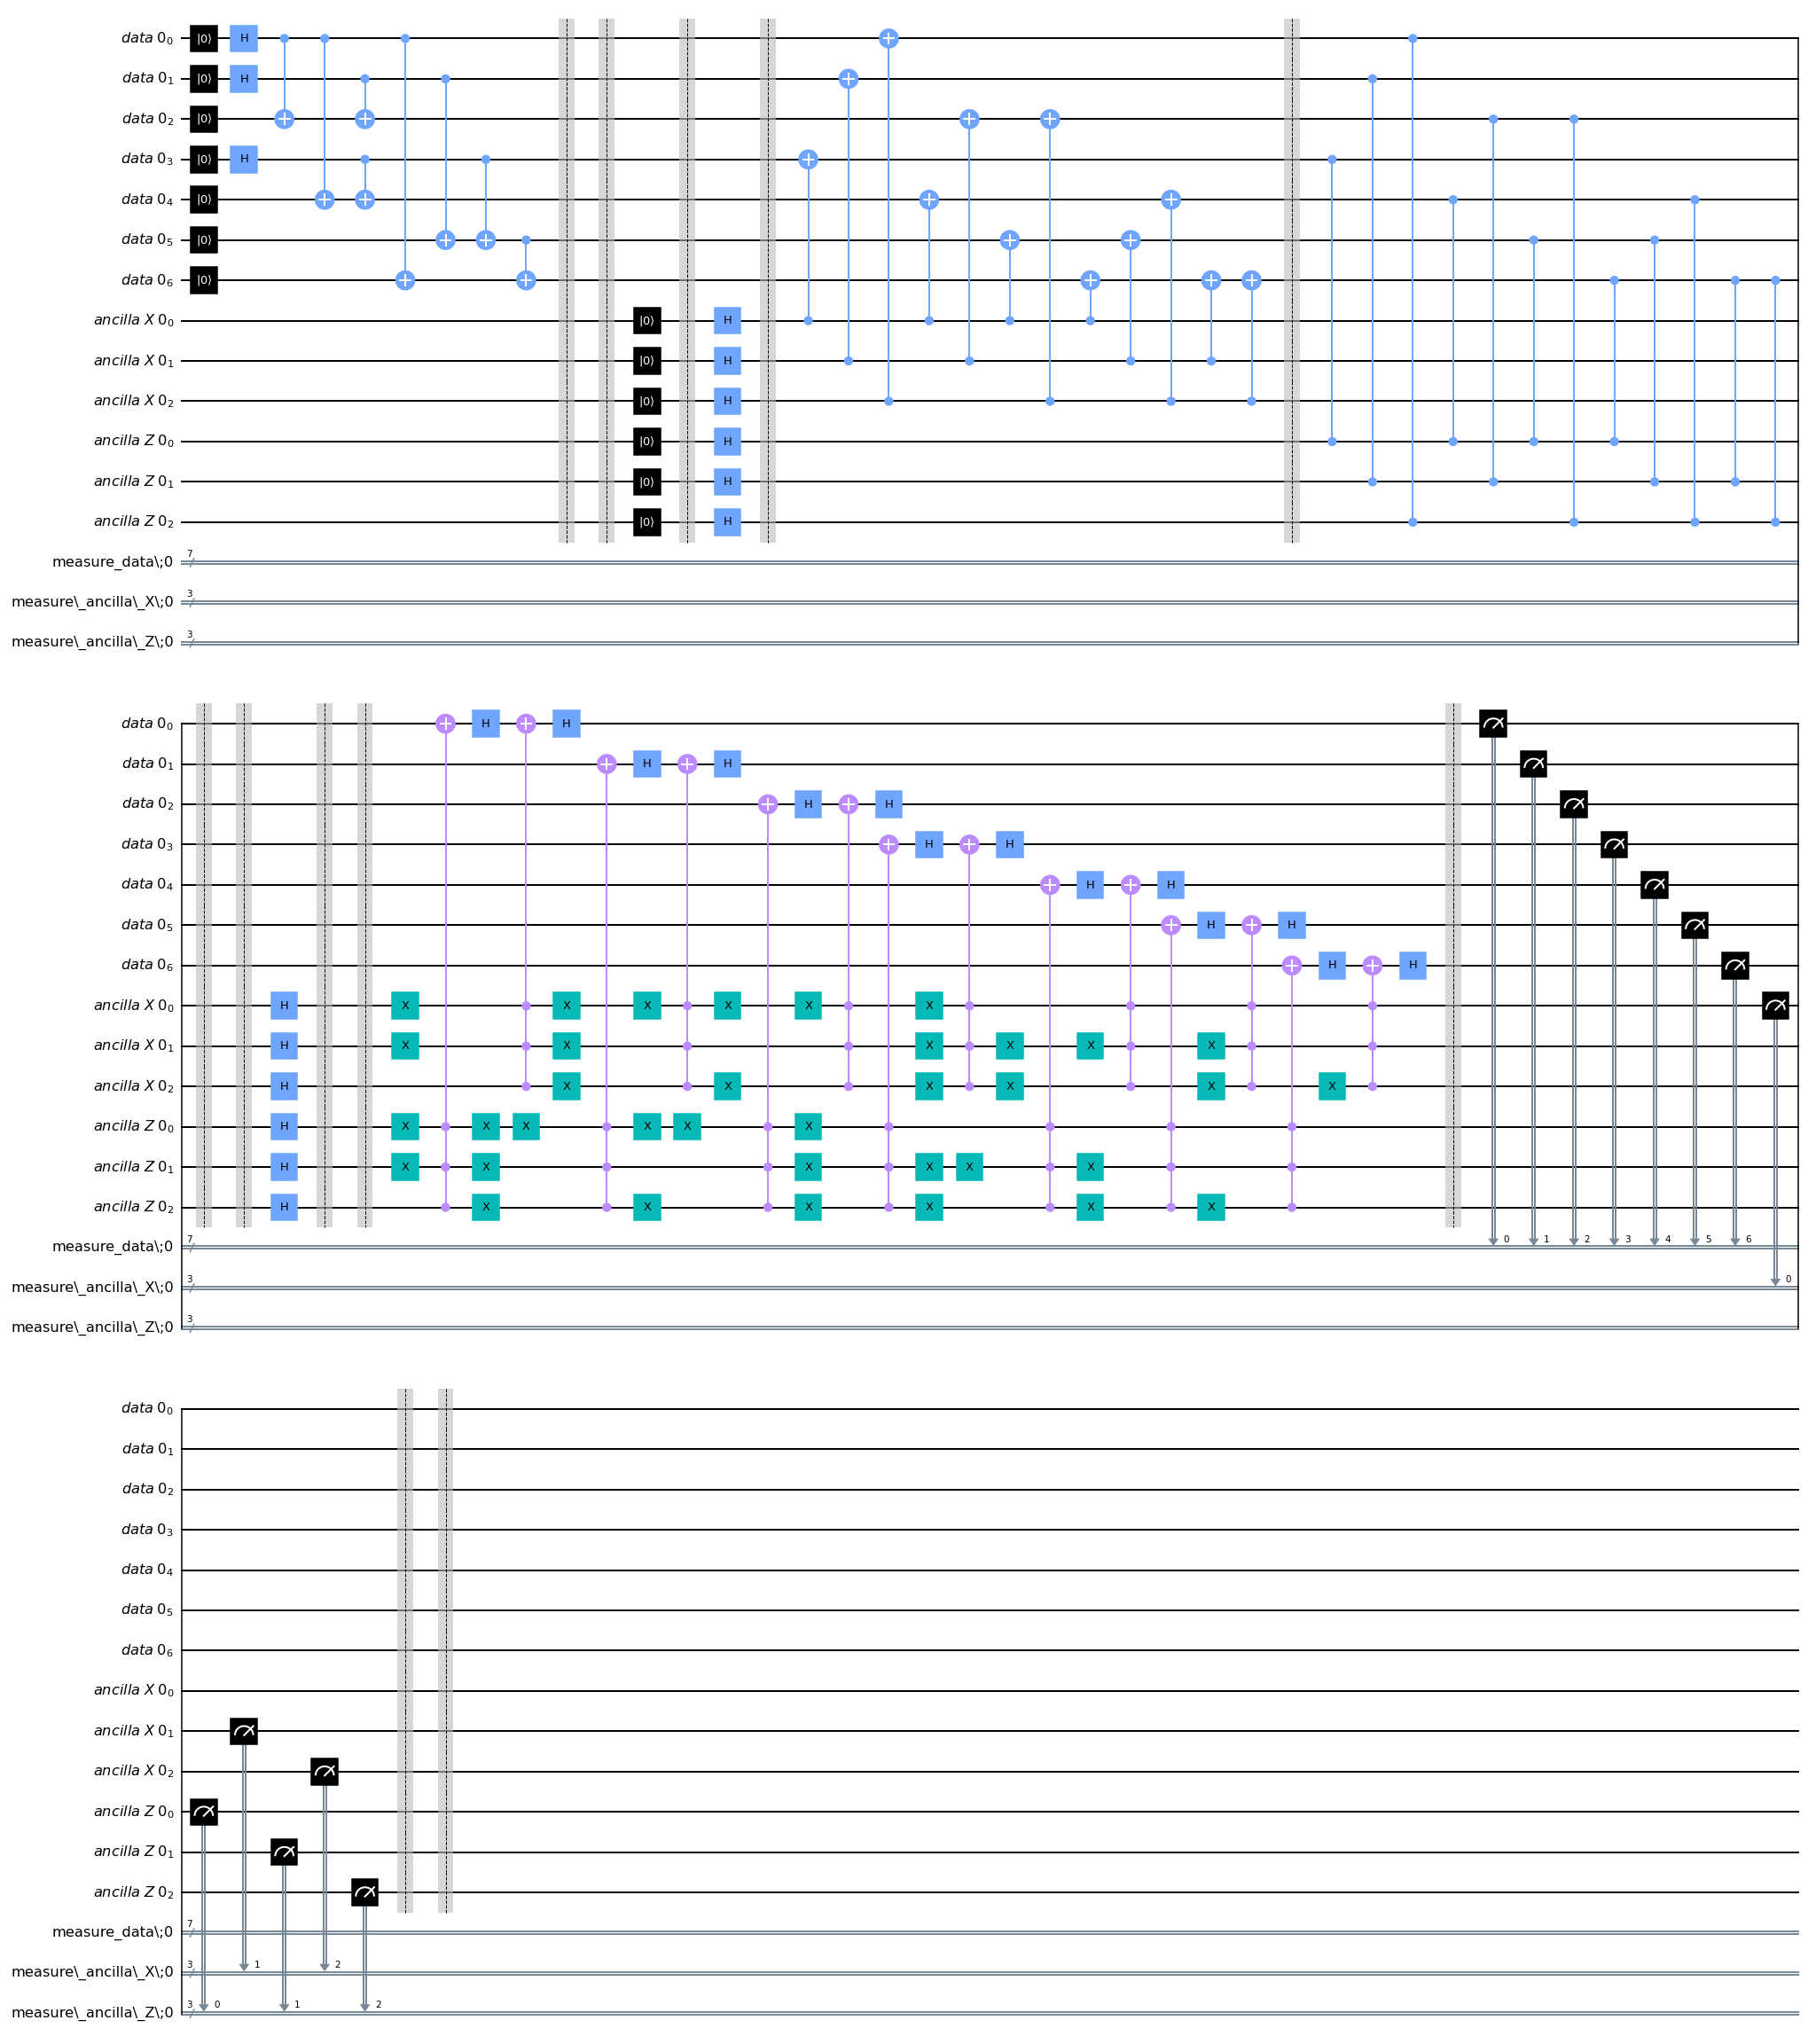

In [6]:
qubit.draw(output = 'mpl', filename = 'Steane_code_error_correction_circuit.jpg', fold = 40)

Draw transpiled circuit

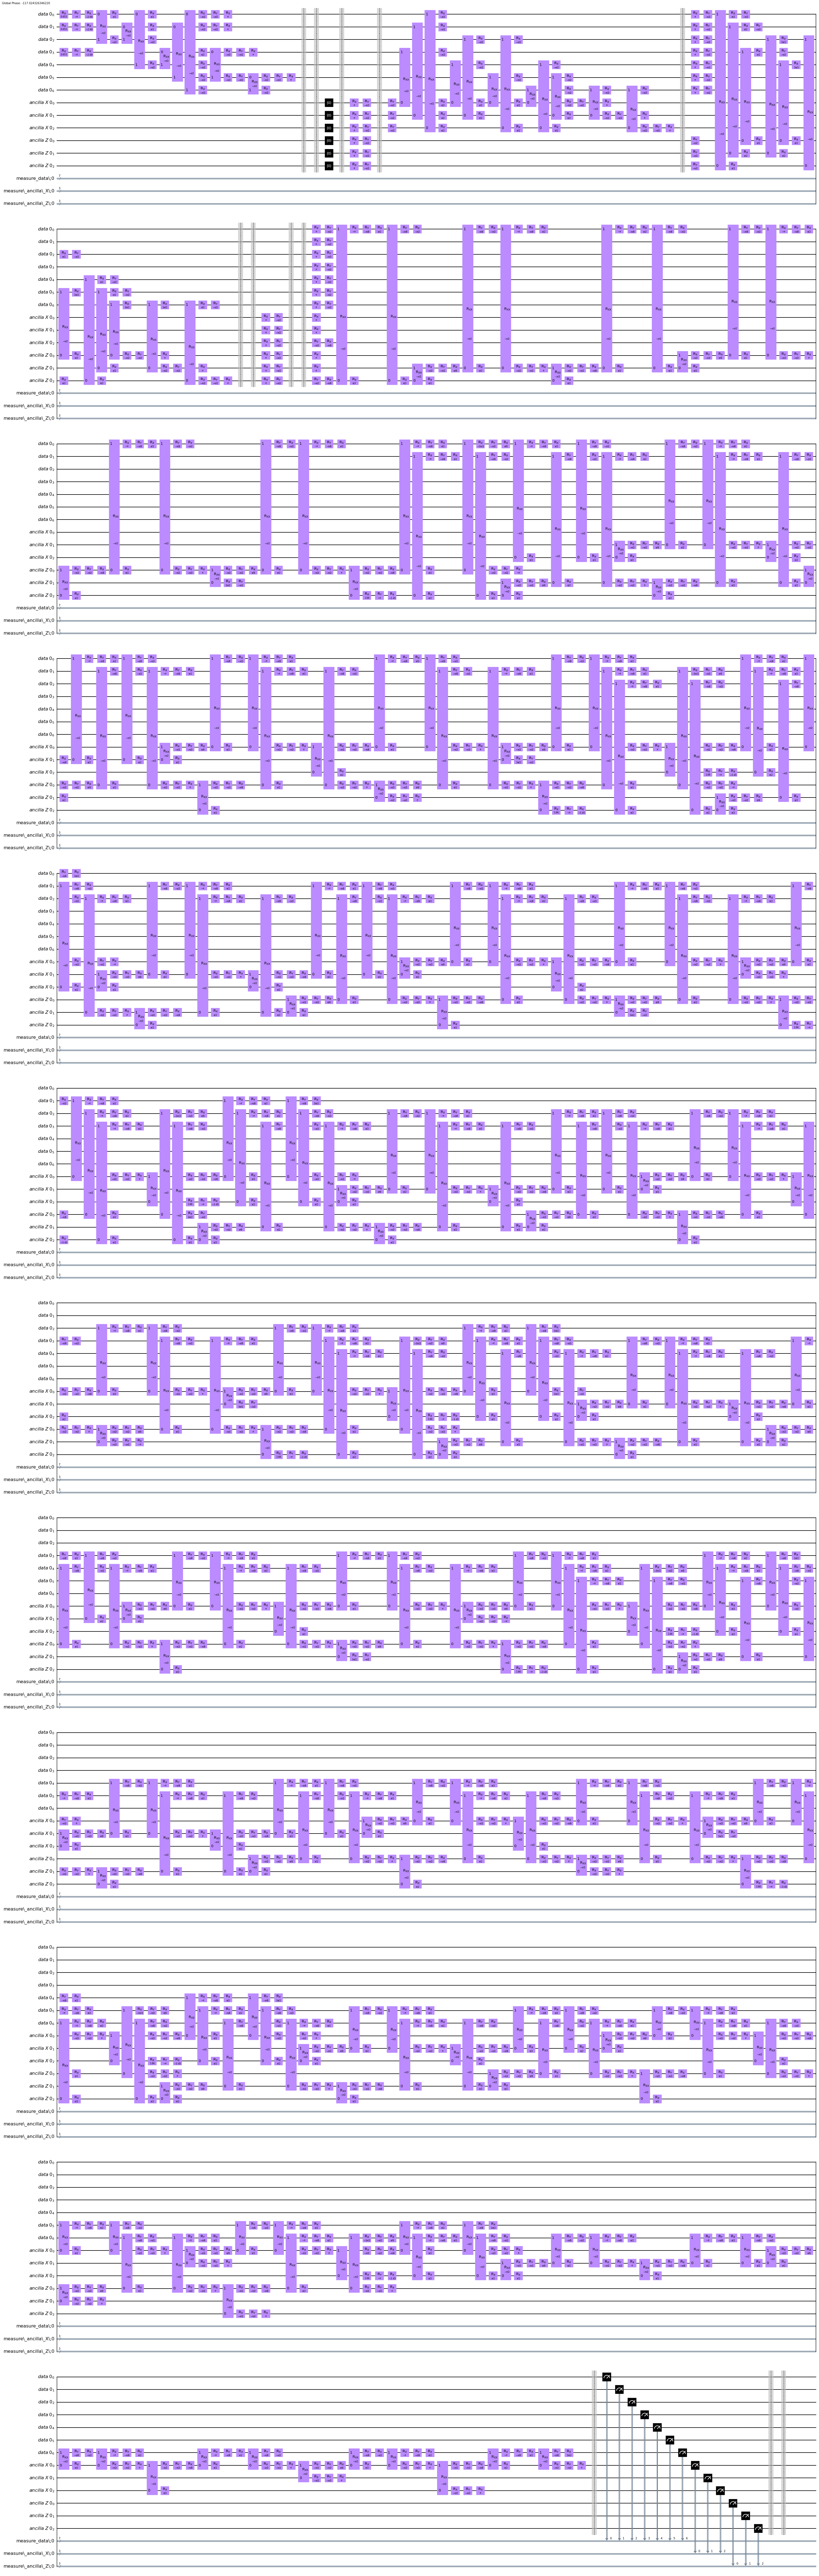

In [7]:
qt.draw(output = 'mpl', filename = 'Steane_code_error_correction_circuit_transpiled.jpg', fold = 60)